In [1]:
import math

import numpy as np
import pandas as pd

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt

from collections import deque

import time

In [2]:
def generate_service_times(x, n):
    # Exponentially distributed
    service_times = np.random.exponential(1/x, n)
    # Gamma distributed
    # service_times = np.random.gamma(x[0], x[1], n) # Mean = x[0]x[1], Variance = x[0]x[1]^2
    return service_times

In [1]:
def F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= w:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*w))/theta_2 + (x-w)))
    else:
        return 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(w-x))-np.exp(-theta_2*w))/theta_2)
    
    
def inverse_F(x, w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return w - (1-np.exp(-theta_2*w))/theta_2 - np.log(1-x)*np.exp(theta_1*price)/lam
    else:
        return (1/theta_2)*np.log(1 - (theta_2/lam)*np.exp(theta_1*price+theta_2*w)*np.log(1-x))
    
    
def gradient_inverse_F(x, w, gradient_w, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    if x >= F(w, w, price, model_vars):
        return (1 - np.exp(-theta_2*w))*gradient_w - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-x)
    else:        
        return (theta_1 + theta_2*gradient_w)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*w)/np.log(1-x))

In [4]:
def queue_simulation(price, model_vars):
    
    current_arrival_time = 0
    server_workload = 0
    
    w_plus = []
    w_minus = []
    
    temp_zeta = np.random.random()
    zeta = [temp_zeta]
    interarrival_times = [inverse_F(temp_zeta, 0, price, model_vars)] # Time until opening customer opens the busy period has been appended
    
    service_times = []
##################################################################################################################################   
    flag = 1
    
    while flag == 1:
        w_minus.append(server_workload)
        
        service_time = np.random.exponential(1)
        service_times.append(service_time)
        server_workload += service_time
        
        zeta.append(np.random.random())
        interarrival_time = inverse_F(zeta[-1], server_workload, price, model_vars)
        current_arrival_time += interarrival_time
        
        server_workload = max(0, server_workload - interarrival_time)
        
        if server_workload == 0:
            flag = 0
        
    w_minus = np.array(w_minus)
    w_plus = np.array(w_plus)
    interarrival_times = np.array(interarrival_times)
    zeta = np.array(zeta)
    service_times = np.array(service_times)
    
    return [w_minus, w_plus, interarrival_times, zeta]

In [5]:
def revenue_gradient_estimator(w_minus, w_plus, interarrival_times, zeta, price, model_vars):
    
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    
    n_customers = np.size(w_plus)
    
    estimator_term_1 = np.mean(interarrival_times)
    estimator_term_2 = 0
    
    gradient_waiting_time = 0
    
    for i in range(n_customers):
        if i == 0:
            estimator_term_2 += (1/n_customers)*gradient_inverse_F(zeta[0], 0, 0, price, model_vars)
        else:
            estimator_term_2 += (1/n_customers)*gradient_inverse_F(zeta[i], w_plus[i-1], gradient_waiting_time, price, model_vars)
        
        if w_minus[i] == 0:
            gradient_waiting_time = 0
        else:
            gradient_waiting_time -= gradient_inverse_F(zeta[i], w_plus[i-1], gradient_waiting_time, price, model_vars)
    
    revenue_grad_est = 1/estimator_term_1 - price*estimator_term_2/estimator_term_1**2
    return revenue_grad_est

In [6]:
def implement_IPA(n_iters, initial_price, model_vars):
    
    price = initial_price
    price_iterates = [initial_price]
    
    for i in range(1, n_iters+1):
        [w_minus, w_plus, interarrival_times, zeta] = queue_simulation(price, model_vars)
        
        revenue_grad_est = revenue_gradient_estimator(w_minus, w_plus, interarrival_times, zeta, price, model_vars)
        
        learning_rate = 10/np.power(i, 1)
        price = price + learning_rate*revenue_grad_est
        
        price_iterates.append(price)
        
        # print(i)
    
    return price_iterates

In [7]:
n_iters = 1000
initial_price = 50
model_vars = [20, 0.1, 0.2]

price_iterates = implement_IPA(n_iters, initial_price, model_vars)

Text(0.5, 1.0, 'IPA gradient estimator for price convergence')

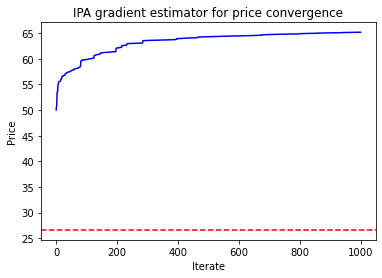

In [8]:
## Plots

optimal_price = 26.6

plt.plot(price_iterates, color = "blue")
plt.axhline(optimal_price, color = "red", linestyle="dashed")

plt.xlabel("Iterate")
plt.ylabel("Price")
plt.title("IPA gradient estimator for price convergence")